In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.autograd import Variable

import random
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# random seed
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

cuda


In [4]:
# prepeared dataset(MNIST)
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST( # MNIST
    root = '/data',
    train=True,
    download=True,
    transform = transform
)

test_dataset = datasets.MNIST(
    root = '/data',
    train=False,
    download=True,
    transform = transform
)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

In [5]:
import model

# parameter of Gaussian noise
myu = 0
sigma = 100

# hyper parameter
rules = "FA"
epochs = 10
learning_rate = 0.0001
image_size = 28 * 28

Epoch: 1/10, Train_Loss: 0.28936616539446786
Epoch: 1/10, Test_Loss: 0.21444828053818474
Epoch: 2/10, Train_Loss: 0.19358427606538922
Epoch: 2/10, Test_Loss: 0.17522651504112197
Epoch: 3/10, Train_Loss: 0.16567427339330157
Epoch: 3/10, Test_Loss: 0.154724070354353
Epoch: 4/10, Train_Loss: 0.1494497600267691
Epoch: 4/10, Test_Loss: 0.14202728575166268
Epoch: 5/10, Train_Loss: 0.13878289475115632
Epoch: 5/10, Test_Loss: 0.13330420436738413
Epoch: 6/10, Train_Loss: 0.13126258575903582
Epoch: 6/10, Test_Loss: 0.12667677825010276
Epoch: 7/10, Train_Loss: 0.12562436117991202
Epoch: 7/10, Test_Loss: 0.12191601474828358
Epoch: 8/10, Train_Loss: 0.12108544846460509
Epoch: 8/10, Test_Loss: 0.1178882827487173
Epoch: 9/10, Train_Loss: 0.11750578086005091
Epoch: 9/10, Test_Loss: 0.11446188409117204
Epoch: 10/10, Train_Loss: 0.1143970321903605
Epoch: 10/10, Test_Loss: 0.1118739280330984
[0.21444828053818474, 0.17522651504112197, 0.154724070354353, 0.14202728575166268, 0.13330420436738413, 0.12667677

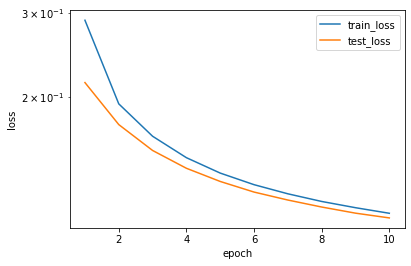

In [6]:
model = model.FA_Autoencoder(rules, 784, 200, 784).to(device)

# initialized weight
if rules == "FA_Ex-50%":
    m = model.linear2.weight_fa < 0.5
    m = m.to(torch.float)
    model.linear2.weight_fa = m - 0.5

elif rules == "FA_Ex-80%":
    m = model.linear2.weight_fa < 0.8
    m = m.to(torch.float)
    model.linear2.weight_fa = m - 0.5

# loss function
criterion = nn.BCELoss()
# optimizer
optimizer = optimizers.RMSprop(model.parameters(), lr=learning_rate)

# log
train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    train_loss_sum = 0.
    test_loss_sum = 0.
    
    # training----------------------------------------------
    model.train()
    for (train_images, _) in train_dataloader:
        
        n = train_images*255
        # tensor to numpy
        train_mnist_image = n.numpy()
        
        # generated noise_image
        gaussian_noise = np.random.normal(myu, sigma, train_mnist_image.shape)
        train_noise_img = train_mnist_image.astype(np.float64) + gaussian_noise
        train_noise_img = train_noise_img/255
        train_noise_images= torch.from_numpy(train_noise_img.astype(np.float32)).clone()
    
        train_images = train_images.to(device)
        train_noise_images = train_noise_images.to(device)
        
        # flatten
        train_noise_images = train_noise_images.view(-1, image_size)
        train_images = train_images.view(-1, image_size)
        
        # predicted
        train_outputs = model(train_noise_images)
        
        # calcurated loss
        train_loss = criterion(train_outputs, train_images)
        train_loss_sum += train_loss.item()

        # initilized optimizer
        optimizer.zero_grad()

        # updated weight
        train_loss.backward()
        optimizer.step()
        
        # initilized optimizer
        optimizer.zero_grad()
    
    print(f"Epoch: {epoch + 1}/{epochs}, Train_Loss: {train_loss_sum/len(train_dataloader)}")
    
    # appended loss to a log
    train_loss_history.append(train_loss_sum/len(train_dataloader))
    
    # evaluate--------------------------------------------
    model.eval()
    with torch.no_grad():
        for (test_images, _) in test_dataloader:
            n = test_images*255
            test_mnist_image = n.numpy()
        
            # generated noise_image
            gaussian_noise = np.random.normal(myu, sigma, test_mnist_image.shape)
            test_noise_img = test_mnist_image.astype(np.float64) + gaussian_noise
            test_noise_img = test_noise_img/255
            test_noise_images= torch.from_numpy(test_noise_img.astype(np.float32)).clone()
    
            # GPU
            test_images = test_images.to(device)
            test_noise_images = test_noise_images.to(device)
            
            # flatten
            test_images = test_images.view(-1, image_size)
            test_noise_images = test_noise_images.view(-1, image_size)
            
            # predicted
            test_outputs = model(test_noise_images)
            
            # calcurate loss
            test_loss = criterion(test_outputs, test_images)
            test_loss_sum += test_loss.item()
            
        print(f"Epoch: {epoch + 1}/{epochs}, Test_Loss: {test_loss_sum/len(test_dataloader)}")
        
        # appended loss to a log
        test_loss_history.append(test_loss_sum/len(test_dataloader))

plt.plot(list(range(1, epochs + 1)), train_loss_history, label = "train_loss")
plt.plot(list(range(1, epochs + 1)), test_loss_history, label = "test_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()

In [ ]:
H = 8
W = 8
fig, ax = plt.subplots(H, W)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# extracted test_image
test_img, test_label = next(iter(test_dataloader))
test_img = test_img[0:H*W]
n_test = test_img*255

test_myu = myu
test_sigma = sigma

mnist_test_image = n_test.numpy()

# generated noise_image
gaussian_noise = np.random.normal(test_myu, test_sigma, mnist_test_image.shape)
test_noise_image = mnist_test_image + gaussian_noise
test_noise_image = test_noise_image / 255

# generated test_image
mnist_test_image = mnist_test_image / 255

# numpy to tensor
test_noise_img= torch.from_numpy(test_noise_image.astype(np.float32)).clone()
test_noise_img = test_noise_img.to(device)

image_num = 0
model.eval()
for i in range(H):
    for j in range(W):
        test_noise_img_one = test_noise_img[image_num].view(-1, image_size)
        # predicted generated image
        test_img_rec = model(test_noise_img_one)
        
        for k, image in enumerate([test_img[0], test_img_rec]):
            # tensor to numpy
            image = image.view(28, 28).detach().cpu().numpy()
            ax[i, j].imshow(image, cmap='binary_r')
            ax[i, j].axis('off')
        
        image_num = image_num + 1
plt.show() 

In [ ]:
# original image
fig, ax = plt.subplots(H, W)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

image_num = 0
for i in range(H):
    for j in range(W):
        pre_test_img = mnist_test_image[image_num].reshape((28, 28))
        
        ax[i, j].imshow(pre_test_img, cmap='binary_r')
        ax[i, j].axis('off')
        
        image_num = image_num + 1

plt.show() 

In [ ]:
# noise image
fig, ax = plt.subplots(H, W)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

image_num = 0
for i in range(H):
    for j in range(W):
        new_test_img = test_noise_image[image_num].reshape((28, 28))
        
        ax[i, j].imshow(new_test_img, cmap='binary_r')
        ax[i, j].axis('off')
        
        image_num = image_num + 1

plt.show() 